In [7]:
%pylab inline
!pip install JSAnimation

Populating the interactive namespace from numpy and matplotlib
  Preparing metadata (setup.py) ... done
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11405 sha256=b77730388ccb8ff4ce46021dca6c9ce9be273f5714453f744bfaed6c854085ce
  Stored in directory: /root/.cache/pip/wheels/1e/16/64/028f540fe8f5eae5026a423bfd88356248074379b79f27b646
Successfully built JSAnimation


**Building a Robot Simulator in 3D with Translational Dynamics**

In [80]:
# Perfect sensor
def sense(x):
  return x

In [91]:
def simulate(Δt, x, u, m=1, g=9.8):
    # Control input affects the acceleration
    dx = array([x[3], x[4], x[5], u[0]/m, u[1]/m, u[2]/m])

    # Include the gravity in the acceleration in z
    dx[5] += - g

    # Euler integration
    x += Δt * dx

    # Simulate the floor (Plastic collision)
    if x[2] < 0:
        x[2] = 0  # z = 0
        x[5] = 0  # vz = 0

    return x

**Control**: Control Policy in case where robot goes 10 to 15 in z

In [161]:
def control(t, y):
    # Desired height
    desired_height = 15

    # Current position
    current_height = y[2]  # Current height (z-coordinate)

    # Estimated and actual mass
    estimated_mass = 1.0  # Estimated mass used in the controller
    actual_mass = 0.8  # Actual mass of the robot

    # Proportional and derivative gains
    Kp = 3.0  # Proportional gain
    Kd = 0.2  # Derivative gain

    # Calculate error and derivative of error
    error = desired_height - current_height  # Height error
    previous_error = control.previous_error if hasattr(control, 'previous_error') else 0  # Previous height error
    error_derivative = (error - previous_error) / (t - control.previous_time) if hasattr(control, 'previous_time') else 0  # Derivative of height error

    # Adjust control input based on mass difference
    mass_scaling_factor = estimated_mass / actual_mass
    uz = (Kp * error + Kd * error_derivative) / mass_scaling_factor  # Adjusted control input

    # Update previous error and time
    control.previous_error = error
    control.previous_time = t

    ux = 0
    uy = 0
    return [ux, uy, uz]

**Running Simulator**

In [162]:
tf = 10.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

# Initial conditions
x = array([0., 0., 10., 0.,0.,0.])
x_log = [copy(x)]

for t in time[:-1]:
    y = sense(x)
    u = control(t, y)
    x = simulate(Δt, x, u)
    x_log.append(copy(x))

x_log = array(x_log)

**Results:** We can start analyzing how the height changes with respect to time

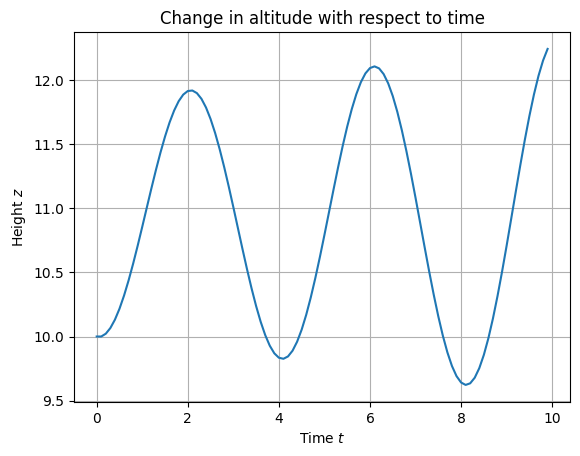

In [163]:
fig, ax = plt.subplots()
ax.plot(time[:-1], x_log[:-1, 2])  # Adjusted slicing to match dimensions
ax.set(title="Change in altitude with respect to time", xlabel="Time $t$", ylabel="Height $z$")
ax.grid()
plt.show()

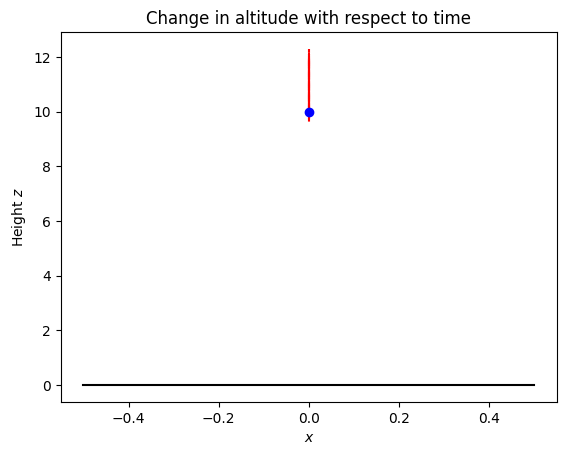

In [164]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()

def animate(t):
    ax.clear()

    # Path
    ax.plot(x_log[:,0], x_log[:,2], 'r--')

    # Initial conditions
    ax.plot(x_log[t,0], x_log[t,2], 'bo')

    # Plot floor
    ax.plot([-0.5,0.5], [0,0], 'k-')

    ax.set(title="Change in altitude with respect to time", xlabel="$x$", ylabel="Height $z$")

anim = animation.FuncAnimation(fig, animate, frames=len(x_log), interval=60)

HTML(anim.to_jshtml())